In [1]:
include("DelayedMatrices.jl")
include("TurtleSearch.jl")
using .DelayedMatrices, .TurtleSearch

In [2]:
include("eom.jl")
import .GoldbergerWiseEoM

In [4]:
using Plots, LaTeXStrings

In [14]:
function g2_m_perturb(l2, xrange, u=u, k=k, yₘ=π)
    g2s0 = exp10.(range(xrange..., 100))
    m2s0 = 4l2*(2k+u)*u^2/(3k)*(1-exp(2k*yₘ))/(1-exp((4k+2u)*yₘ)) * (1 .- (4k+2u) ./g2s0)
    ms0 = sqrt.(m2s0)
    return g2s0, ms0
end

g2_m_perturb (generic function with 1 method)

In [ ]:
function next!(poses)
    t = Turtles(max(poses...))
    inds = bisearch(t, m)
    xs = [m.xaxis(inds[1])]
    ys = [m.yaxis(inds[2])]
    while nothing != next!(t, m)
        inds = bisearch(t, m)
        push!(xs,m.xaxis(inds[1]))
        push!(ys,m.yaxis(inds[2]))
    end
    poses = findfirstseed!(m, map(x->x+CartesianIndex(0,1), poses)...)
    return xs, ys
end
function g2_m_numerical(l2, xrange, yrange, u=u, k=k, φP=1e-1; logscaled = true, nSeeds = 1)
    paramsearch_g2_m = paramsearch(l2=l2, φP=φP)
    m = LazyMatrix(zeros(50,50), paramsearch_g2_m, xrange, yrange, logscaled = logscaled)
    poses = findfirstseed!(m, CartesianIndex(1, 1), CartesianIndex(1, 2))
    @assert !isnothing(poses) "no seed found"
    for i = 1:nSeeds
        xs, ys = next!(poses)
    end
end

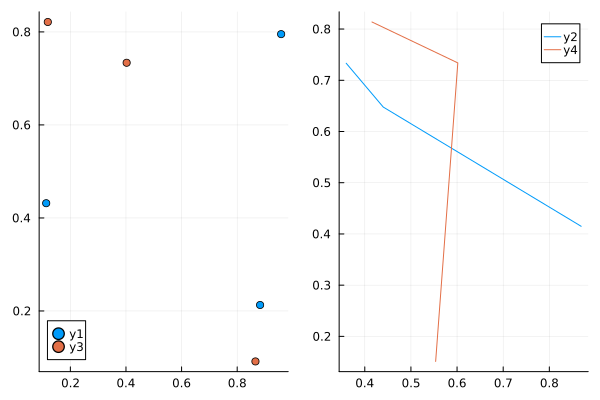

In [13]:
# f1 = plot()
# f2 = plot()
f = plot(layout=(1,2))
scatter!(f[1],rand(3),rand(3))
plot!(f[2],rand(3),rand(3))
scatter!(f[1],rand(3),rand(3))
plot!(f[2],rand(3),rand(3))
display(f)